## Import Packages

In [1]:
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import os

%matplotlib inline

## Helper Functions

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    Draws lines mapping out full extend of lane
    
    Separates line segments by their slope ((y2-y1)/(x2-x1)) to decide 
    which segments are part of the left line vs. the right line.  
    Averages the position of each of the lines and 
    extrapolates them to the top and bottom of the lane.
    
    Draws `lines` with `color` and `thickness`. Mutates input image 
    by drawing lines in place.
    """ 
    
    # determine image height and width
    img_height = img.shape[0]
    img_width = img.shape[1]


    # create array of slopes and intersects
    # line in lines holds coordinates as [x1, y1, x2, y2]
    # NOTE that y-axis is flipped and y-coordinates are measured from top!
    slopes = (lines[:,:,3] - lines[:,:,1]) / (lines[:,:,2] - lines[:,:,0]) 
    intercepts = lines[:,:,1] - lines[:,:,0] * slopes

            
    # determine index of minimum slope line (immediately left of lane) 
    # and of maximum slope line (immediately right of lane) 
    # 
    # REMEMBER that y-axis is flipped:
    # left lines have negative slope and high intercept
    # righ lines have positive slope and low intercept
    max_slope_idx = slopes.argmax(axis=0)
    min_slope_idx = slopes.argmin(axis=0)
    
    # determine indices, slopes, intercepts of lines on the left and of lines on the right of the lane
    # don't consider lines whose slope or intercept deviates too much from respective values of min/max slope line
    right_lines_idxs = np.where(np.all(np.hstack((slopes - slopes[max_slope_idx] < 0.25, 
                                  intercepts - intercepts[max_slope_idx] < (0.25 * img_height))), axis=1))
    left_lines_idxs = np.where(np.all(np.hstack((slopes - slopes[min_slope_idx] < 0.25, 
                                  intercepts - intercepts[min_slope_idx] < (0.25 * img_height))), axis=1))
    right_slopes = slopes[right_lines_idxs]
    right_intercepts = intercepts[right_lines_idxs]
    left_slopes = slopes[left_lines_idxs]
    left_intercepts = intercepts[left_lines_idxs]

    # calculate left and right line by averaging slopes and intercepts of lines on respective side
    # and extrapolate lines roughly to edge and center
    output_lines = np.zeros(shape=(1,2,4), dtype=np.int32)

    if left_slopes.shape[0] > 0:
        left_line = [np.sum(left_slopes) / left_slopes.shape[0], 
                     np.sum(left_intercepts) / left_intercepts.shape[0]]
        x_bottom_left = (img_height - left_line[1]) / left_line[0]
        x_top_left = (img_height * .575 - left_line[1]) / left_line[0]
        if (x_bottom_left >= 0):
            output_lines[0][0] =[x_bottom_left, img_height, x_top_left, img_height * .575]
            # DEBUG
            # output_lines[0][0]=[0,0,0,0]
            
    if right_slopes.shape[0] > 0:
        right_line = [np.sum(right_slopes) / right_slopes.shape[0], 
                      np.sum(right_intercepts) / right_intercepts.shape[0]]
        x_bottom_right = (img_height - right_line[1]) / right_line[0]
        x_top_right = (img_height * .575 - right_line[1]) / right_line[0]
        if (x_bottom_right <= img_width):
            output_lines[0][1]=[x_bottom_right, img_height, x_top_right, img_height * .575]
            # DEBUG
            # output_lines[0][1]=[0,0,0,0]
            
    # write left anf right line onto image
    for line in output_lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Lane Detection Pipeline  

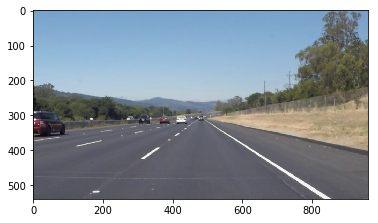

In [3]:
# load image
img = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(img)

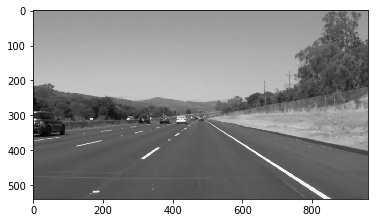

In [4]:
# convert image to grayscale
gray_img = grayscale(img) 
plt.imshow(gray_img, cmap = 'gray')

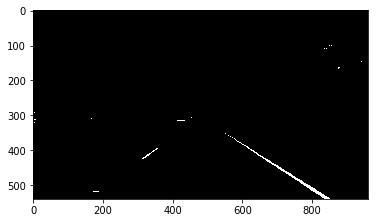

In [5]:
# create mask for yellow and white image parts
## convert original RGB image to HSV image
hsv_img = hsv(img)

## define yellow and white color ranges in HSV
lower_yel = np.array([20,100,100])
upper_yel = np.array([30,255,255])
lower_wht = np.array([0,0,235])
upper_wht = np.array([255,255,255])

## create yellow mask by isolating yellow in HSV image
yellow_mask = cv2.inRange(hsv_img, lower_yel, upper_yel)
## create white mask by isolating white in HSV image
white_mask = cv2.inRange(hsv_img, lower_wht, upper_wht)

## combine yellow and white mask into one
combined_mask = cv2.bitwise_or(yellow_mask, white_mask)
plt.imshow(combined_mask, cmap='gray')

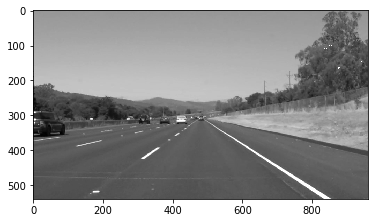

In [6]:
# create image where all lanes have same color by applying yellow or white mask to grayscale image
single_color_lanes_img = cv2.bitwise_or(gray_img, combined_mask)
plt.imshow(single_color_lanes_img, cmap='gray')

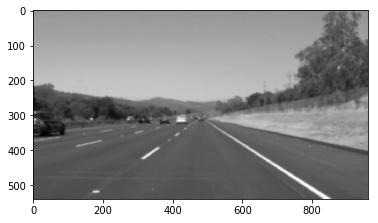

In [7]:
# apply Gaussian blur
kernel_size = 11
blurred_img = gaussian_blur(single_color_lanes_img, kernel_size)
plt.imshow(blurred_img, cmap='gray')

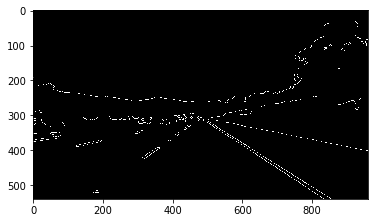

In [8]:
# run Canny edge detection
canny_low_threshold = 50
canny_high_threshold = 100
edges_img = canny(blurred_img,canny_low_threshold,canny_high_threshold)
plt.imshow(edges_img, cmap='gray')

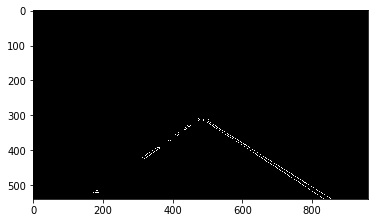

In [9]:
# Define a region of interest and mask away the other parts of the image
# NOTE that due to flipped y-axis, y-coordinates are measured from top
img_width = img.shape[1]
img_height = img.shape[0]


vertices = np.array([[(0, img_height),
                      (img_width * .475, img_height * .575), 
                      (img_width * .525, img_height * .575), 
                      (img_width, img_height)]], 
                    dtype=np.int32)

masked_img = region_of_interest(edges_img, vertices)
plt.imshow(masked_img, cmap='gray')

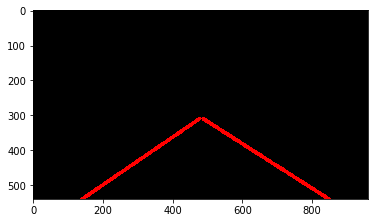

In [10]:
# apply Hough transform and consolidate as well as extrapolate resulting lines
hough_rho = 3
hough_theta = np.pi / 180
hough_threshold = 70
hough_min_line_length = 70
hough_max_line_gap = 250

hough_img = hough_lines(masked_img, 
                        hough_rho, 
                        hough_theta, 
                        hough_threshold, 
                        hough_min_line_length, 
                        hough_max_line_gap)

plt.imshow(hough_img, cmap='gray')

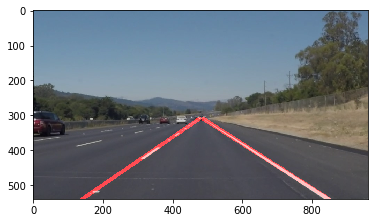

In [11]:
# apply Hough lines to the original image
final_img = weighted_img(hough_img, img)
 
plt.imshow(final_img) 

## Test on Images
Applying pipeline to all images in the `test_images/` directory 

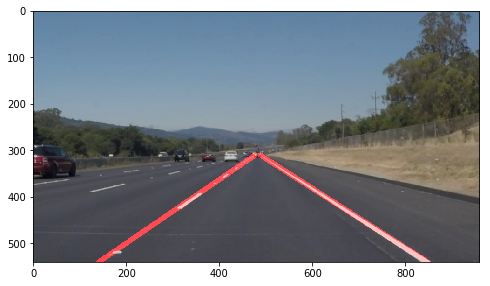

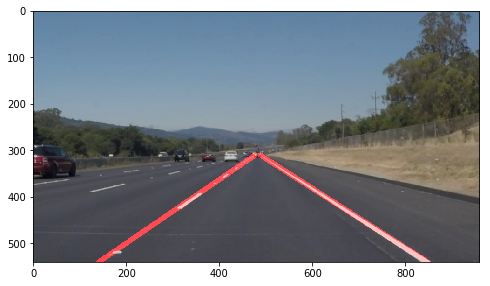

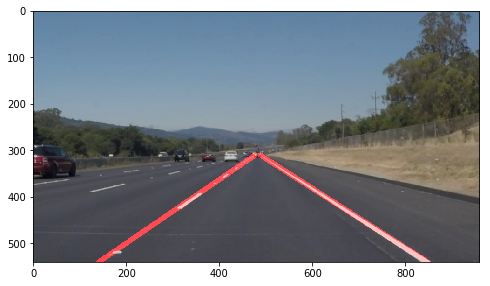

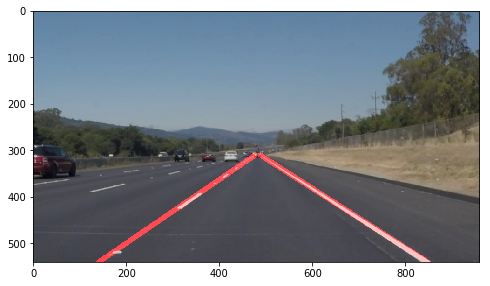

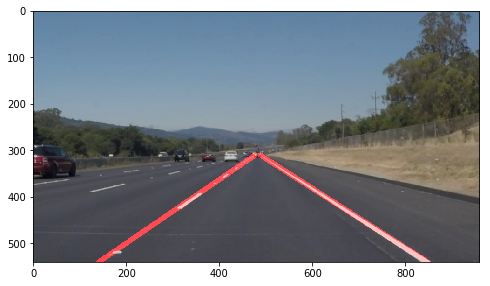

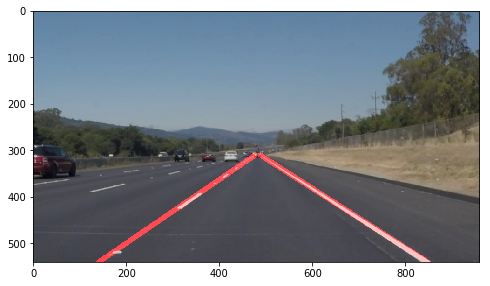

In [12]:
for filename in os.listdir('test_images/'):
    # load image
    img = mpimg.imread('test_images/solidWhiteRight.jpg')
    
    # convert image to grayscale
    gray_img = grayscale(img) 
    
    # create mask for yellow and white image parts
    ## convert original RGB image to HSV image
    hsv_img = hsv(img)

    ## define yellow and white color ranges in HSV
    lower_yel = np.array([20,100,100])
    upper_yel = np.array([30,255,255])
    lower_wht = np.array([0,0,235])
    upper_wht = np.array([255,255,255])

    ## create yellow mask by isolating yellow in HSV image
    yellow_mask = cv2.inRange(hsv_img, lower_yel, upper_yel)
    ## create white mask by isolating white in HSV image
    white_mask = cv2.inRange(hsv_img, lower_wht, upper_wht)

    ## combine yellow and white mask into one
    combined_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    # create image where all lanes have same color by applying yellow or white mask to grayscale image
    single_color_lanes_img = cv2.bitwise_or(gray_img, combined_mask)
    
    # apply Gaussian blur
    kernel_size = 11
    blurred_img = gaussian_blur(single_color_lanes_img, kernel_size)
    
    # run Canny edge detection
    canny_low_threshold = 50
    canny_high_threshold = 100
    edges_img = canny(blurred_img,canny_low_threshold,canny_high_threshold)
    
    # Define a region of interest and mask away the other parts of the image
    # NOTE that due to flipped y-axis, y-coordinates are measured from top
    img_width = img.shape[1]
    img_height = img.shape[0]
    
    vertices = np.array([[(0, img_height),
                          (img_width * .475, img_height * .575), 
                          (img_width * .525, img_height * .575), 
                          (img_width, img_height)]], 
                        dtype=np.int32)
    
    masked_img = region_of_interest(edges_img, vertices)
    
    # apply Hough transform and consolidate as well as extrapolate resulting lines
    hough_rho = 3
    hough_theta = np.pi / 180
    hough_threshold = 70
    hough_min_line_length = 70
    hough_max_line_gap = 250
    
    hough_img = hough_lines(masked_img, 
                            hough_rho, 
                            hough_theta, 
                            hough_threshold, 
                            hough_min_line_length, 
                            hough_max_line_gap)
    
    # apply Hough lines to the original image
    final_img = weighted_img(hough_img, img)
    
    fig = plt.figure(figsize=(8,10))
    plt.imshow(final_img)

## Test on Videos

Applying pipeline to all videos in the `test_videos/` directory: 

- `solidWhiteRight.mp4`

- `solidYellowLeft.mp4`

- `challenge.mp4`

In [13]:
# import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
# transform pipeline into function to be passed to fl_image()
def process_image(img):
    # convert image to grayscale
    gray_img = grayscale(img) 
    
    # create mask for yellow and white image parts
    ## convert original RGB image to HSV image
    hsv_img = hsv(img)

    ## define yellow and white color ranges in HSV
    lower_yel = np.array([20,100,100])
    upper_yel = np.array([30,255,255])
    lower_wht = np.array([0,0,235])
    upper_wht = np.array([255,255,255])

    ## create yellow mask by isolating yellow in HSV image
    yellow_mask = cv2.inRange(hsv_img, lower_yel, upper_yel)
    ## create white mask by isolating white in HSV image
    white_mask = cv2.inRange(hsv_img, lower_wht, upper_wht)

    ## combine yellow and white mask into one
    combined_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    # create image where all lanes have same color by applying yellow or white mask to grayscale image
    single_color_lanes_img = cv2.bitwise_or(gray_img, combined_mask)
    
    # apply Gaussian blur
    kernel_size = 11
    blurred_img = gaussian_blur(single_color_lanes_img, kernel_size)
    
    # run Canny edge detection
    canny_low_threshold = 50
    canny_high_threshold = 100
    edges_img = canny(blurred_img, canny_low_threshold, canny_high_threshold)
    
    # Define a region of interest and mask away the other parts of the image
    # NOTE that due to flipped y-axis, y-coordinates are measured from top
    img_width = img.shape[1]
    img_height = img.shape[0]
    
    vertices = np.array([[(0, img_height),
                          (img_width * .475, img_height * .575), 
                          (img_width * .525, img_height * .575), 
                          (img_width, img_height)]], 
                        dtype=np.int32)
    
    masked_img = region_of_interest(edges_img, vertices)
    
    # apply Hough transform and consolidate as well as extrapolate resulting lines
    hough_rho = 3
    hough_theta = np.pi / 180
    hough_threshold = 70
    hough_min_line_length = 70
    hough_max_line_gap = 250
    
    hough_img = hough_lines(masked_img, 
                            hough_rho, 
                            hough_theta, 
                            hough_threshold, 
                            hough_min_line_length, 
                            hough_max_line_gap)
    
    # apply Hough lines to the original image
    final_img = weighted_img(hough_img, img)
    
    return final_img

`solidWhiteRight.mp4`

In [15]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

# uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('test_videos/solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image) # NOTE that this function expects colour images
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:09<00:00, 23.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 7.5 s, sys: 938 ms, total: 8.44 s
Wall time: 10.7 s


In [16]:
# need to delete cell and create new one to display new output (as browser seems to cache output?)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

`solidYellowLeft.mp4`

In [17]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'

# uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4").subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:28<00:00, 25.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 22.9 s, sys: 2.53 s, total: 25.5 s
Wall time: 30 s


In [18]:
# need to delete cell and create new one to display new output (as browser seems to cache output?)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

`challenge.mp4`

In [19]:
challenge_output = 'test_videos_output/challenge.mp4'

# uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:21<00:00, 12.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 15.9 s, sys: 1.87 s, total: 17.8 s
Wall time: 23.9 s


In [20]:
# need to delete cell and create new one to display new output (as browser seems to cache output?)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))